In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn
import torch.nn.functional as F

In [2]:
# データの用意
training_data = datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 12827717.90it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 394828.31it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 2738019.16it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 4918804.23it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



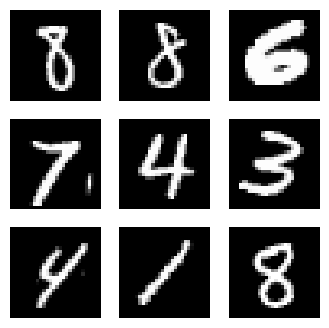

In [3]:
# 入力画像を描画してみる
figure = plt.figure(figsize=(4, 4))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")

plt.show()

### ハイパーパラメータ

画像の幅と高さが28x28ピクセルであるので、入力層には784のニューロンが必要になる。
また、出力が入力のようになることを再現するように学習するので、出力のニューロン数は入力層と一致させる。<br>

潜在変数とラベルの関係を２次元で可視化するため、まずは潜在変数の数を2とする。

In [61]:
# ハイパーパラメータの設定
image_size = 28
n_z = 2  # 潜在変数の数

a = 0.01
epochs = 100
batch_size = 32
mid_dim = 196

In [62]:
train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)

### モデルの構築

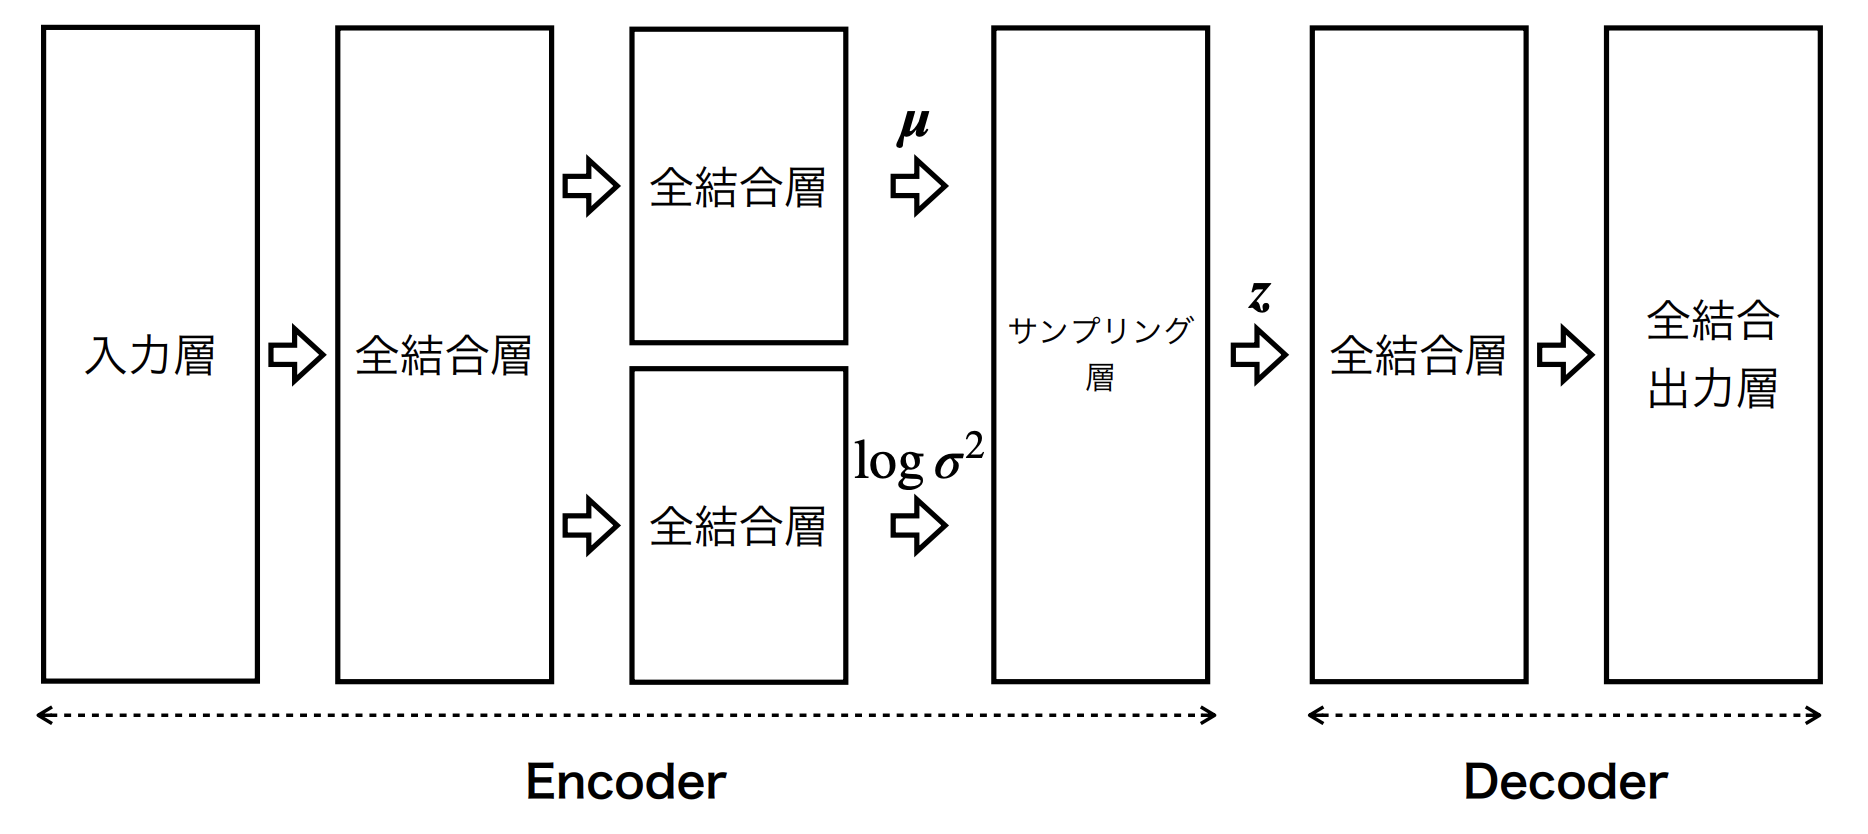

### 潜在変数

初期の潜在変数生成方法
VAEの設計上、エンコーダの役割は、入力データを潜在空間にマッピングし、その潜在空間に従う**正規分布（平均
𝜇
μ、分散
𝜎
2
 ）**を学習することです。初期の方法では、単純に次のように潜在変数
𝑧
 を生成していました。

𝑧
∼
𝑁
(
𝜇
,
𝜎
2
)
つまり、潜在変数
𝑧
を生成する際に、「平均
𝜇 と分散
𝜎
2
  の正規分布」から直接サンプリングしていました。しかし、この方法ではサンプリングのランダム性がエンコーダのパラメータ（すなわち、𝜇と 𝜎を求める層のパラメータ）に依存しているため、エンコーダのパラメータに対して勾配を計算することができませんでした。

#### リパラメータ化トリックによる解決策
この問題を解決するために、リパラメータ化トリックが導入されました。リパラメータ化トリックでは、サンプリング過程を次のように分解します：

𝑧
=
𝜇
+
𝜎
×
𝜖
ここで、
𝜖
∼
𝑁
(
0
,
1
)
は平均0、分散1の標準正規分布からサンプリングされる独立したノイズです。この形式により、サンプリングのランダム性がパラメータ
𝜇や
𝜎から独立します。この結果、潜在変数
𝑧はエンコーダのパラメータ
𝜇と
𝜎の関数として表現できるため、エンコーダのパラメータに対する勾配計算が可能になります。

In [63]:
class VAE(nn.Module):
  def __init__(self, image_size: tuple[int | int], mid_dim: int, n_z: int) -> None:
    super().__init__()
    self.in_dim = self.size_checker(image_size)

    self.encoder_mid = nn.Linear(self.in_dim, mid_dim)
    self.encoder_avg = nn.Linear(mid_dim, n_z) # 平均を求める層
    self.encoder_stand = nn.Linear(mid_dim, n_z) # 標準偏差を求める層

    self.decoder_mid = nn.Linear(n_z, mid_dim)
    self.decoder_out = nn.Linear(mid_dim, self.in_dim)

    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    z = self.encoder(x) # z -> サンプリングされた値
    out = self.decoder(z)
    return out

  def encoder(self, x: torch.Tensor) -> torch.Tensor:
    x = x.view(-1, self.in_dim)

    x = self.relu(self.encoder_mid(x))
    self.avg = self.encoder_avg(x)
    self.stand = self.encoder_stand(x)

    std = torch.exp(0.5*self.stand)
    eps = torch.randn_like(std)
    return self.avg + std * eps # 潜在変数(reparameterization trick)

  def decoder(self, z: torch.Tensor) -> torch.Tensor:
    x = self.relu(self.decoder_mid(z))
    x = self.sigmoid(self.decoder_out(x))
    return x

  def size_checker(self, image_size: tuple[int] | int) -> int:
    if isinstance(image_size, tuple):
      return image_size[0] * image_size[1]
    else:
      return image_size * image_size

  def loss(self, x: torch.Tensor, x_pred: torch.Tensor) -> tuple[torch.Tensor]:
    """
    Args:
      x: 真の値（入力と出力が一致するように学習するためxを受け取る）
      x_pred: 予測値
    """
    x = x.view(-1, self.in_dim)

    rec_loss = F.binary_cross_entropy(x_pred, x, reduction="sum")
    reg_loss = 0.5 * torch.sum(self.avg**2 + torch.exp(self.stand) - self.stand - 1)
    return (rec_loss, reg_loss)

vae = VAE(image_size, mid_dim, n_z)
vae.cuda()
print(vae)


VAE(
  (encoder_mid): Linear(in_features=784, out_features=196, bias=True)
  (encoder_avg): Linear(in_features=196, out_features=2, bias=True)
  (encoder_stand): Linear(in_features=196, out_features=2, bias=True)
  (decoder_mid): Linear(in_features=2, out_features=196, bias=True)
  (decoder_out): Linear(in_features=196, out_features=784, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


### 学習

In [64]:
from torch import optim

# Adam
optimizer = optim.Adam(vae.parameters())

# 損失のログ
rec_error_record = []
reg_error_record = []
total_error_record = []

for i in range(epochs):
  vae.train()
  loss_rec = 0
  loss_reg = 0
  loss_total = 0

  for j, (x, _) in enumerate(train_loader):
    x = x.cuda()
    y_pred = vae(x)
    lrec, lreg = vae.loss(x, y_pred)
    loss = lrec + lreg
    loss_rec += lrec.item()
    loss_reg += lreg.item()
    loss_total += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  loss_rec /= j+1
  loss_reg /= j+1
  loss_total /= j+1
  rec_error_record.append(loss_rec)
  reg_error_record.append(loss_reg)
  total_error_record.append(loss_total)

  if i%10 == 0:
      print("Epoch:", i, "Loss_Rec:", loss_rec, "Loss_Reg:", loss_reg, "Loss_Total:", loss_total)

Epoch: 0 Loss_Rec: 5550.185973177084 Loss_Reg: 171.00643227678935 Loss_Total: 5721.192405989584
Epoch: 10 Loss_Rec: 4733.739532291666 Loss_Reg: 186.83441736653646 Loss_Total: 4920.573955078125
Epoch: 20 Loss_Rec: 4617.51619375 Loss_Reg: 194.29023465983073 Loss_Total: 4811.806425390625
Epoch: 30 Loss_Rec: 4549.2518473958335 Loss_Reg: 198.93408269856772 Loss_Total: 4748.1859294270835
Epoch: 40 Loss_Rec: 4508.8591108072915 Loss_Reg: 200.6025995361328 Loss_Total: 4709.461711848959
Epoch: 50 Loss_Rec: 4480.283847005208 Loss_Reg: 202.64314274088542 Loss_Total: 4682.926995703125
Epoch: 60 Loss_Rec: 4460.304939583333 Loss_Reg: 203.7967381998698 Loss_Total: 4664.101670963541
Epoch: 70 Loss_Rec: 4445.703659244792 Loss_Reg: 205.3920001627604 Loss_Total: 4651.095656640625
Epoch: 80 Loss_Rec: 4433.051025260416 Loss_Reg: 205.8403723470052 Loss_Total: 4638.891399348959
Epoch: 90 Loss_Rec: 4420.783964973958 Loss_Reg: 206.24986727701824 Loss_Total: 4627.033833463542


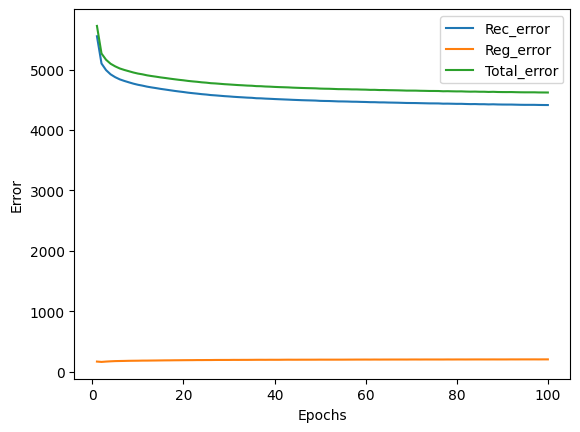

In [65]:
plt.plot(range(1, len(rec_error_record)+1), rec_error_record, label="Rec_error")
plt.plot(range(1, len(reg_error_record)+1), reg_error_record, label="Reg_error")
plt.plot(range(1, len(total_error_record)+1), total_error_record, label="Total_error")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

### 潜在変数の可視化
潜在変数を平面にプロットすることで2次元の潜在変数がどのように表現できるのかを可視化する。

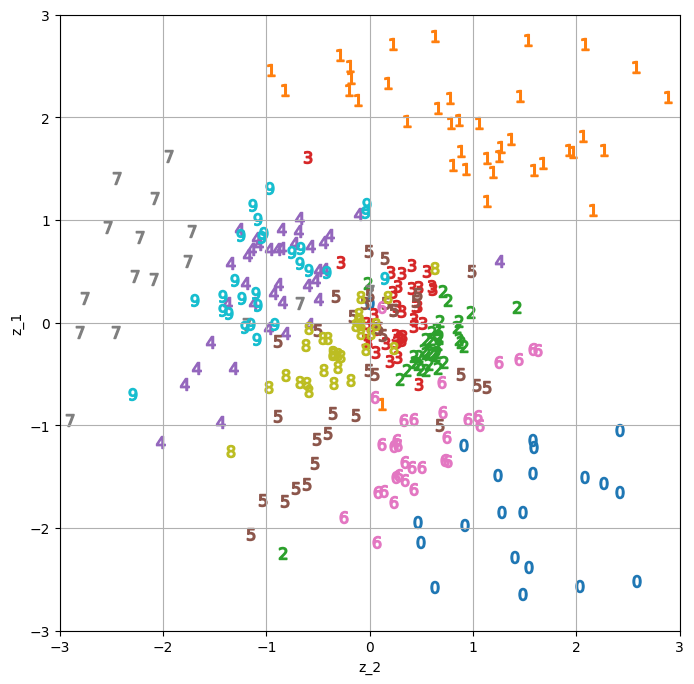

In [66]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# 評価モード
vae.eval()

# 潜在変数とラベルの蓄積用リスト
z_list = []
t_list = []

# サンプルを複数回取得して蓄積
num_batches = 10  # 必要なバッチ数を指定
for _ in range(num_batches):
    x, t = next(iter(train_loader))  # 1バッチ取得
    x = x.cuda()

    # 潜在変数を計算
    z = vae.encoder(x)
    z = z.cpu().detach().numpy()
    t = t.cpu().detach().numpy()  # ラベルをnumpyに変換

    # 潜在変数とラベルを蓄積
    z_list.append(z)
    t_list.append(t)

# 蓄積したデータを配列に変換
z_all = np.concatenate(z_list, axis=0)
t_all = np.concatenate(t_list, axis=0)

# 潜在変数を平面にプロット
plt.figure(figsize=(8, 8))
for i in range(10):
    zt = z_all[t_all == i]
    z_1 = zt[:, 0]  # y軸
    z_2 = zt[:, 1]  # x軸
    marker = "$" + str(i) + "$"  # 数値をマーカーに
    plt.scatter(z_2.tolist(), z_1.tolist(), marker=marker, s=75)

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.grid()
plt.show()


### 画像の生成

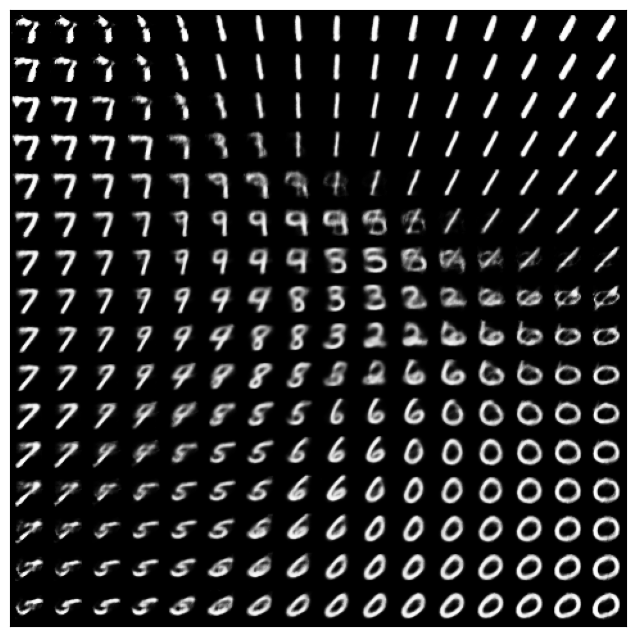

In [67]:
# 画像の設定
n_img = 16  # 画像を16x16並べる
img_size_spaced = image_size + 2
matrix_image = np.zeros((img_size_spaced*n_img, img_size_spaced*n_img))  # 全体の画像

# 潜在変数
z_1 = np.linspace(3, -3, n_img)  # 行
z_2 = np.linspace(-3, 3, n_img)  # 列

#  潜在変数を変化させて画像を生成
for i, z1 in enumerate(z_1):
    for j, z2 in enumerate(z_2):
        z = torch.tensor([[z1, z2]], dtype=torch.float)
        z = z.cuda()
        y = vae.decoder(z)  # Decoder
        y = y.cpu().detach().numpy()
        image = y.reshape(image_size, image_size)
        top = i*img_size_spaced
        left = j*img_size_spaced
        matrix_image[top : top+image_size, left : left+image_size] = image

plt.figure(figsize=(8, 8))
plt.imshow(matrix_image.tolist(), cmap="Greys_r")
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # 軸目盛りのラベルと線を消す
plt.show()

### 潜在変数を3次元で表現する

In [68]:
# 潜在変数の数を更新
n_z = 3

In [71]:
vae = VAE(image_size, mid_dim, n_z)
vae.cuda()
print(vae)

VAE(
  (encoder_mid): Linear(in_features=784, out_features=196, bias=True)
  (encoder_avg): Linear(in_features=196, out_features=3, bias=True)
  (encoder_stand): Linear(in_features=196, out_features=3, bias=True)
  (decoder_mid): Linear(in_features=3, out_features=196, bias=True)
  (decoder_out): Linear(in_features=196, out_features=784, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [72]:
# 再学習
from torch import optim

# Adam
optimizer = optim.Adam(vae.parameters())

# 損失のログ
rec_error_record = []
reg_error_record = []
total_error_record = []

for i in range(epochs):
  vae.train()
  loss_rec = 0
  loss_reg = 0
  loss_total = 0

  for j, (x, _) in enumerate(train_loader):
    x = x.cuda()
    y_pred = vae(x)
    lrec, lreg = vae.loss(x, y_pred)
    loss = lrec + lreg
    loss_rec += lrec.item()
    loss_reg += lreg.item()
    loss_total += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  loss_rec /= j+1
  loss_reg /= j+1
  loss_total /= j+1
  rec_error_record.append(loss_rec)
  reg_error_record.append(loss_reg)
  total_error_record.append(loss_total)

  if i%10 == 0:
      print("Epoch:", i, "Loss_Rec:", loss_rec, "Loss_Reg:", loss_reg, "Loss_Total:", loss_total)

Epoch: 0 Loss_Rec: 5176.512230859375 Loss_Reg: 227.5453815410296 Loss_Total: 5404.057616666667
Epoch: 10 Loss_Rec: 4258.09567890625 Loss_Reg: 247.80819895833332 Loss_Total: 4505.90387890625
Epoch: 20 Loss_Rec: 4151.846178385416 Loss_Reg: 256.5687796223958 Loss_Total: 4408.414962109375
Epoch: 30 Loss_Rec: 4095.805831640625 Loss_Reg: 261.1869930501302 Loss_Total: 4356.9928243489585
Epoch: 40 Loss_Rec: 4061.882253515625 Loss_Reg: 263.4739200032552 Loss_Total: 4325.356173697916
Epoch: 50 Loss_Rec: 4039.378336328125 Loss_Reg: 265.59041939290364 Loss_Total: 4304.968750911458
Epoch: 60 Loss_Rec: 4020.5665278645833 Loss_Reg: 267.3093978271484 Loss_Total: 4287.875920182291
Epoch: 70 Loss_Rec: 4006.514425130208 Loss_Reg: 267.91242670898436 Loss_Total: 4274.426857552084
Epoch: 80 Loss_Rec: 3993.965830078125 Loss_Reg: 269.12514825032554 Loss_Total: 4263.090979557292
Epoch: 90 Loss_Rec: 3984.2038536458335 Loss_Reg: 269.9759170247396 Loss_Total: 4254.179768229166


In [78]:
# Google Colabでインタラクティブな3Dプロットを行うための設定
!pip install ipympl  # 初回のみ実行

%matplotlib widget
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [81]:
# plotlyをインストール（初回のみ）
!pip install plotly

import numpy as np
import torch
import plotly.graph_objects as go

# 評価モード
vae.eval()

# 潜在変数とラベルの蓄積用リスト
z_list = []
t_list = []

# サンプルを複数回取得して蓄積
num_batches = 10  # 必要なバッチ数を指定
for _ in range(num_batches):
    x, t = next(iter(train_loader))  # 1バッチ取得
    x = x.cuda()

    # 潜在変数を計算
    z = vae.encoder(x)
    z = z.cpu().detach().numpy()
    t = t.cpu().detach().numpy()  # ラベルをnumpyに変換

    # 潜在変数とラベルを蓄積
    z_list.append(z)
    t_list.append(t)

# 蓄積したデータを配列に変換
z_all = np.concatenate(z_list, axis=0)
t_all = np.concatenate(t_list, axis=0)

# Plotlyで3Dプロット
fig = go.Figure()

# 各クラスごとにプロット
for i in range(10):
    zt = z_all[t_all == i]
    z_1 = zt[:, 0]  # x軸
    z_2 = zt[:, 1]  # y軸
    z_3 = zt[:, 2]  # z軸

    fig.add_trace(go.Scatter3d(
        x=z_1,
        y=z_2,
        z=z_3,
        mode='markers',
        marker=dict(size=5),
        name=f"Class {i}"
    ))

# 軸ラベルの設定
fig.update_layout(scene=dict(
                    xaxis_title="z_1",
                    yaxis_title="z_2",
                    zaxis_title="z_3"),
                  width=700,
                  margin=dict(r=20, b=10, l=10, t=10))

# プロットを表示
fig.show()


In [1]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt

# ランダムな潜在変数を指定
z_random = torch.randn((1, 3), dtype=torch.float32)  # 3次元潜在変数
z_random = z_random.cuda()  # GPUへ転送

# デコーダーで画像を生成
vae.eval()  # 評価モード
with torch.no_grad():
    y = vae.decoder(z_random)

# 出力情報の確認
print("Generated tensor shape:", y.shape)  # yの形状
print("Generated tensor min:", y.min())
print("Generated tensor max:", y.max())

# リシェイプして表示
image = y.cpu().detach().numpy().reshape((28, 28))
print("Image shape after reshape:", image.shape)  # 変換後の形状

# 描画を確認
plt.figure(figsize=(4, 4))
plt.imshow(image, cmap="gray")  # グレースケールマップ
plt.axis("off")
plt.show()


NameError: name 'vae' is not defined